# Hyperparameters and Model Validation

# 超参数和模型验证

> In the previous section, we saw the basic recipe for applying a supervised machine learning model:

> 1. Choose a class of model
2. Choose model hyperparameters
3. Fit the model to the training data
4. Use the model to predict labels for new data

上一节中，我们学习了应用有监督机器学习的基本配方：

1. 选择一个模型类别
2. 选择模型超参数
3. 将模型拟合到训练数据上
4. 将模型在新数据上进行预测

> The first two pieces of this—the choice of model and choice of hyperparameters—are perhaps the most important part of using these tools and techniques effectively.
In order to make an informed choice, we need a way to *validate* that our model and our hyperparameters are a good fit to the data.
While this may sound simple, there are some pitfalls that you must avoid to do this effectively.

上面的前两步，选择模型类别和超参数，也许是有效使用这些工具和技术的最关键部分。为了作出一个明智的选择，我们需要一个方式来*验证*我们的模型和超参数，看它们是否拟合数据集。虽然这个方式听起来很简单，但是里面有很多坑你需要避开。

## Thinking about Model Validation

## 思考模型验证

> In principle, model validation is very simple: after choosing a model and its hyperparameters, we can estimate how effective it is by applying it to some of the training data and comparing the prediction to the known value.

原则上，模型验证非常简单：选择了模型类别和它的超参数之后，我们将它应用到一些训练数据上进行训练，然后将它的预测值和已知值进行比较。

> The following sections first show a naive approach to model validation and why it
fails, before exploring the use of holdout sets and cross-validation for more robust
model evaluation.

下面首先介绍一个原始的模型验证方法和为什么它不正确，然后再介绍使用预留出的子集及交叉验证来获得更健壮的模型评估结果。

### Model validation the wrong way

### 错误的模型验证

> Let's demonstrate the naive approach to validation using the Iris data, which we saw in the previous section.
We will start by loading the data:

让我们展示使用鸢尾花数据集来进行模型验证的一个原始方法，首导入数据：

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

> Next we choose a model and hyperparameters. Here we'll use a *k*-neighbors classifier with ``n_neighbors=1``.
This is a very simple and intuitive model that says "the label of an unknown point is the same as the label of its closest training point:"

下面我们选择模型和超参数。这里我们会使用*k近邻*分类器，超参数`n_neighbors=1`。这是一个非常简单和直观的模型，它认为“未知的点的标签与距离它最近的训练点的标签是一样的”。

In [2]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

> Then we train the model, and use it to predict labels for data we already know:

然后我们训练模型，用训练好的模型来预测训练集的标签：

In [3]:
model.fit(X, y)
y_model = model.predict(X)

> Finally, we compute the fraction of correctly labeled points:

最后，我们计算得到准确率：

In [4]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

> We see an accuracy score of 1.0, which indicates that 100% of points were correctly labeled by our model!
But is this truly measuring the expected accuracy? Have we really come upon a model that we expect to be correct 100% of the time?

我们看到准确率是1.0，这表示100%的点都被我们的模型正确标记了。但是这是否代表这我们模型真实的准确率？我们是否真的能碰到一个模型能够100%正确的处理所有数据？

> As you may have gathered, the answer is no.
In fact, this approach contains a fundamental flaw: *it trains and evaluates the model on the same data*.
Furthermore, the nearest neighbor model is an *instance-based* estimator that simply stores the training data, and predicts labels by comparing new data to these stored points: except in contrived cases, it will get 100% accuracy *every time!*

可能你从直觉上就能得到答案是否定的。事实上，这个方法有着一个最基本的错误：*使用同样的数据集来训练和评估性能*。并且，最近邻模型是一个*基于实例*的评估器保存训练数据，然后将这些新数据和保存的数据点进行比较来预测标签：除非在人为干预情况下，它总是会获得100%的准确率。

### Model validation the right way: Holdout sets

### 模型验证的正确方式：保留部分数据

> So what can be done?
A better sense of a model's performance can be found using what's known as a *holdout set*: that is, we hold back some subset of the data from the training of the model, and then use this holdout set to check the model performance.
This splitting can be done using the ``train_test_split`` utility in Scikit-Learn:

因此可以怎么做？将一部分数据集*保留*出来不参与训练，并使用它们对模型的性能进行评估才是正确的办法：即我们将数据中的部分子集从训练集中分离出来，然后再将它们预测的结果和预先标记的结果进行对比得到模型性能。这可以通过Scikit-Learn的`train_test_split`工具完成：

In [5]:
from sklearn.model_selection import train_test_split
# 将数据集按照50%分成两个子集-训练集和测试集
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                  train_size=0.5)

# 使用训练集对模型进行拟合
model.fit(X1, y1)

# 使用模型对测试集进行预测，并评估结果
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

0.9066666666666666

> We see here a more reasonable result: the nearest-neighbor classifier is about 90% accurate on this hold-out set.
The hold-out set is similar to unknown data, because the model has not "seen" it before.

这样我们就得到了一个更加合理的结果：最近邻分类器在这样划分了训练集和测试集后，能得到大约90%的准确率。这里保留出的子数据集类似未知的数据，因为模型根本没有*见过*它们。

### Model validation via cross-validation

### 对模型使用交叉验证

> One disadvantage of using a holdout set for model validation is that we have lost a portion of our data to the model training.
In the above case, half the dataset does not contribute to the training of the model!
This is not optimal, and can cause problems – especially if the initial set of training data is small.

上面的保留子数据集来验证模型的方式有一个缺点，那就是我们其中一部分的数据无法参与模型训练过程。在上面例子中，一半的数据集对于训练模型没有任何贡献。这不是最优化的方式，而且可能导致问题，特别是原始训练数据规模比较小的情况下。

> One way to address this is to use *cross-validation*; that is, to do a sequence of fits where each subset of the data is used both as a training set and as a validation set.
Visually, it might look something like this:

解决这个缺点的方法是使用*交叉验证*；也就是使用一系列的拟合过程，其中每次拟合的时候都是用完整的数据集，但是不同的训练集和测试集来进行验证。下面描绘了这个过程：

![](figures/05.03-2-fold-CV.png)
[附录中生成图像的代码](06.00-Figure-Code.ipynb#2-Fold-Cross-Validation)

> Here we do two validation trials, alternately using each half of the data as a holdout set.
Using the split data from before, we could implement it like this:

这里我们使用两次验证过程，每次使用不同的一半数据作为保留的数据集来验证模型。使用上面分好的数据，我们使用下面的代码实现：

In [6]:
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.96, 0.9066666666666666)

> What comes out are two accuracy scores, which we could combine (by, say, taking the mean) to get a better measure of the global model performance.
This particular form of cross-validation is a *two-fold cross-validation*—that is, one in which we have split the data into two sets and used each in turn as a validation set.

上面输出了两个准确率结果，我们可以组合（例如通过取平均值）来获得更好的全局性能结果。上面这个特殊的交叉验证过程被称为*双重检查验证*，也就是我们将数据均分为两个子数据集，然后依次使用它们作为测试集。

> We could expand on this idea to use even more trials, and more folds in the data—for example, here is a visual depiction of five-fold cross-validation:

我们可以将这个方法扩展到更多的拟合过程，将数据划分为更多子集进行更多重训练验证，例如下图是一个五重交叉验证：

![](figures/05.03-5-fold-CV.png)
[附录中生成图像的代码](06.00-Figure-Code.ipynb#5-Fold-Cross-Validation)

> Here we split the data into five groups, and use each of them in turn to evaluate the model fit on the other 4/5 of the data.
This would be rather tedious to do by hand, and so we can use Scikit-Learn's ``cross_val_score`` convenience routine to do it succinctly:

这里我们将数据分成5组，每次使用其中一组来评估模型，其余的4/5用来训练模型。每次都要手动完成这项工作是很无聊的，因此我们可以使用Scikit-Learn的`cross_val_score`工具来直接完整它：

In [7]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

> Repeating the validation across different subsets of the data gives us an even better idea of the performance of the algorithm.

使用不同的子数据集重复对模型进行验证能为我们提供更好的算法性能结果。

> Scikit-Learn implements a number of useful cross-validation schemes that are useful in particular situations; these are implemented via iterators in the ``cross_validation`` module.
For example, we might wish to go to the extreme case in which our number of folds is equal to the number of data points: that is, we train on all points but one in each trial.
This type of cross-validation is known as *leave-one-out* cross validation, and can be used as follows:

Scikit-Learn实现了许多有用的交叉验证方案，它们适合于特定的场景；这些方案都是在`model_selection`模块中实现的。例如，我们可能希望采用一种极端的方案，该方案中数据的分组等于数据的样本数：也就是说，我们使用除了一个数据点外的其他所有数据进行训练。这种交叉验证被成为*leave-one-out*交叉验证，如下例：

译者注：本翻译将所有旧版的`cross_validation`模块改为了`model_selection`模块，下面的LeaveOneOut实例化也修改为无参数的新版本。

In [8]:
from sklearn.model_selection import LeaveOneOut
scores = cross_val_score(model, X, y, cv=LeaveOneOut())
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

> Because we have 150 samples, the leave one out cross-validation yields scores for 150 trials, and the score indicates either successful (1.0) or unsuccessful (0.0) prediction.
Taking the mean of these gives an estimate of the error rate:

因为我们有150个样本，leave-one-out交叉验证会得到150个验证结果，结果只有两种状态：验证成功（1.0）或验证失败（0.0）。对上面的结果数组求平均值能得到一个估计的准确率：

In [9]:
scores.mean()

0.96

> Other cross-validation schemes can be used similarly.
For a description of what is available in Scikit-Learn, use IPython to explore the ``sklearn.cross_validation`` submodule, or take a look at Scikit-Learn's online [cross-validation documentation](http://scikit-learn.org/stable/modules/cross_validation.html).

其他交叉验证方案也是类似的使用。想要查阅Scikit-Learn中可用的交叉验证方案，可以使用IPython来浏览`sklean.model_selection`模块或者浏览Scikit-Learn在线[交叉验证文档](http://scikit-learn.org/stable/modules/cross_validation.html)。

## Selecting the Best Model

## 选择最佳模型

> Now that we've seen the basics of validation and cross-validation, we will go into a litte more depth regarding model selection and selection of hyperparameters.
These issues are some of the most important aspects of the practice of machine learning, and I find that this information is often glossed over in introductory machine learning tutorials.

现在我们已经学习了模型验证和交叉验证的基础，我们可以继续深入了解模型选择和超参数选择的内容。这些话题是机器学习实践中最重要的一些方面，作者发现这部分信息经常在机器学习入门教程中被一笔带过。

> Of core importance is the following question: *if our estimator is underperforming, how should we move forward?*
There are several possible answers:

> - Use a more complicated/more flexible model
- Use a less complicated/less flexible model
- Gather more training samples
- Gather more data to add features to each sample

其中的核心问题是：*我们的评估器是否表现不佳？我们应该如何继续改进？*这可能有如下的答案：

- 使用一个更加复杂或更加灵活的模型
- 使用一个没那么复杂或没那么灵活的模型
- 收集更多的训练样本
- 对每个样本收集更多信息，增加特征

> The answer to this question is often counter-intuitive.
In particular, sometimes using a more complicated model will give worse results, and adding more training samples may not improve your results!
The ability to determine what steps will improve your model is what separates the successful machine learning practitioners from the unsuccessful.

对这个问题的解答经常是反直觉的。比方说有时使用一个更复杂的模型可能会得到一个更差的结果，而增加样本数量不能改进你的结果。决定采用哪些方法步骤来改进模型的能力是成功的机器学习实践者和不成功的实践者的主要区别。

### The Bias-variance trade-off

### 偏差方差的权衡

> Fundamentally, the question of "the best model" is about finding a sweet spot in the tradeoff between *bias* and *variance*.
Consider the following figure, which presents two regression fits to the same dataset:

“最佳模型”问题基本上是关于寻找*偏差*和*方差*的最佳均衡点。考虑下图，这是对同一个数据集的两个回归：

![](figures/05.03-bias-variance.png)
[附录中生成图像的代码](06.00-Figure-Code.ipynb#Bias-Variance-Tradeoff)

> It is clear that neither of these models is a particularly good fit to the data, but they fail in different ways.

很明显这两个模型都不是拟合数据的最佳模型，但是它们失败的地方是不一样的。

> The model on the left attempts to find a straight-line fit through the data.
Because the data are intrinsically more complicated than a straight line, the straight-line model will never be able to describe this dataset well.
Such a model is said to *underfit* the data: that is, it does not have enough model flexibility to suitably account for all the features in the data; another way of saying this is that the model has high *bias*.

左边的模型试图找出一条直线来拟合数据。因为这个数据很明显比直线要复杂的多，因此直线模型不可能很好的描述这个数据集。这样的模型我们成为“欠拟合”：也就是说，它没有提供足够的模型灵活性来反映出数据的所有特征；用另一种说法就是这个模型有着高的*偏差*。

> The model on the right attempts to fit a high-order polynomial through the data.
Here the model fit has enough flexibility to nearly perfectly account for the fine features in the data, but even though it very accurately describes the training data, its precise form seems to be more reflective of the particular noise properties of the data rather than the intrinsic properties of whatever process generated that data.
Such a model is said to *overfit* the data: that is, it has so much model flexibility that the model ends up accounting for random errors as well as the underlying data distribution; another way of saying this is that the model has high *variance*.

右边的模型试图使用一个高阶的多项式来拟合数据。这个模型具有足够的灵活性几乎完美的描述了数据中的特征，虽然它很精确的描述了训练数据，但是它的这种精确性可能更多反映了对数据噪声特征的反映而不是内在主要特征的反映。这样的模型被称为是“过拟合”的：也就是说它有着很好的模型灵活性，甚至反映了数据的随机误差；另一种说法就是这个模型有着高的*方差*。

> To look at this in another light, consider what happens if we use these two models to predict the y-value for some new data.
In the following diagrams, the red/lighter points indicate data that is omitted from the training set:

从另一个角度来看，如果我们使用这两个模型来预测一些新数据的y值的话，下图中的红色/淡色的点代表这数据中从训练集中分出来的数据点：

![](figures/05.03-bias-variance-2.png)
[附录中生成图像的代码](06.00-Figure-Code.ipynb#Bias-Variance-Tradeoff-Metrics)

> The score here is the $R^2$ score, or [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination), which measures how well a model performs relative to a simple mean of the target values. $R^2=1$ indicates a perfect match, $R^2=0$ indicates the model does no better than simply taking the mean of the data, and negative values mean even worse models.
From the scores associated with these two models, we can make an observation that holds more generally:

> - For high-bias models, the performance of the model on the validation set is similar to the performance on the training set.
- For high-variance models, the performance of the model on the validation set is far worse than the performance on the training set.

这里使用的评估标准是$R^2$分值，或者称为[决定系数](https://en.wikipedia.org/wiki/Coefficient_of_determination)，这是用来衡量模型相对目标值的简单平均值比较预测性能的好方法。$R^2=1$代表完全复合，$R^2=0$代表模型与简单取数据平均值没有区别，负数值代表模型的表现还不如简单取平均值。从两个模型的这个分值中，我们可以得到更普遍的结论：

- 对于高偏差的模型来说，模型的性能在测试集上与在训练集上类似。
- 对于高方差的模型来说，模型的性能在测试集上比在训练集上差了非常多。

> If we imagine that we have some ability to tune the model complexity, we would expect the training score and validation score to behave as illustrated in the following figure:

如果想象我们有某种能力能够调节模型的复杂度，我们可以绘制下面的图形代表这训练分数和测试分数的情况：

![](figures/05.03-validation-curve.png)
[附录中生成图像的代码](06.00-Figure-Code.ipynb#Validation-Curve)

> The diagram shown here is often called a *validation curve*, and we see the following essential features:

> - The training score is everywhere higher than the validation score. This is generally the case: the model will be a better fit to data it has seen than to data it has not seen.
- For very low model complexity (a high-bias model), the training data is under-fit, which means that the model is a poor predictor both for the training data and for any previously unseen data.
- For very high model complexity (a high-variance model), the training data is over-fit, which means that the model predicts the training data very well, but fails for any previously unseen data.
- For some intermediate value, the validation curve has a maximum. This level of complexity indicates a suitable trade-off between bias and variance.

这幅图像通常被称为*验证曲线*，我们观察到下面这些关键特征：

- 训练分数在任何地方都比验证分数要高。这基于理论：模型在它见过的数据上会比它没见过的数据上更加拟合。
- 对于低复杂度模型（高偏差模型）来说，训练数据是欠拟合的，这代表着模型即不能很好的预测训练数据也不能很好的预测未知数据。
- 对于非常高复杂度模型（高方法模型）来说，训练数据是过拟合的，这代表着模型能非常好的预测训练数据，但是不能很好的预测未知数据。
- 对于中间部分来说，验证曲线又一个最大值。这个点代表着偏差和方差的最佳平衡点。

> The means of tuning the model complexity varies from model to model; when we discuss individual models in depth in later sections, we will see how each model allows for such tuning.

不同的模型有着不同的模型复杂度调整的含义；当我们在后面章节深入讨论单个模型时，我们会看到每个模型这个方面的调整方法。

### Validation curves in Scikit-Learn

### Scikit-Learn中的验证曲线

> Let's look at an example of using cross-validation to compute the validation curve for a class of models.
Here we will use a *polynomial regression* model: this is a generalized linear model in which the degree of the polynomial is a tunable parameter.
For example, a degree-1 polynomial fits a straight line to the data; for model parameters $a$ and $b$:

下面我们来看一个例子说明使用交叉验证来计算一个模型类别的验证曲线。这里我们将使用*多项式回归*模型：这是一个广义的线性模型，其中的多项式的阶是可调整的参数。例如，一阶的多项式将数据拟合到一条直线上；模型参数有$a$和$b$：

$$
y = ax + b
$$

> A degree-3 polynomial fits a cubic curve to the data; for model parameters $a, b, c, d$:

一个三阶的多项式将数据是配到一条三次方程曲线上；模型参数有$a, b, c, d$：

$$
y = ax^3 + bx^2 + cx + d
$$

> We can generalize this to any number of polynomial features.
In Scikit-Learn, we can implement this with a simple linear regression combined with the polynomial preprocessor.
We will use a *pipeline* to string these operations together (we will discuss polynomial features and pipelines more fully in [Feature Engineering](05.04-Feature-Engineering.ipynb)):

我们可以推广到任意阶的多项式中。在Scikit-Learn中我们可以通过将线性回归与多项式预处理器结合起来实现这个任务。我们会使用*管道*将这些操作串联起来（我们会在[特征工程](05.04-Feature-Engineering.ipynb)中更详细的讨论多项式特征和管道）：

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

> Now let's create some data to which we will fit our model:

现在我们让我们创建一些数据来拟合模型：

In [11]:
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

> We can now visualize our data, along with polynomial fits of several degrees:

现在可以可视化我们的数据，包含着不同阶的多项式匹配结果：

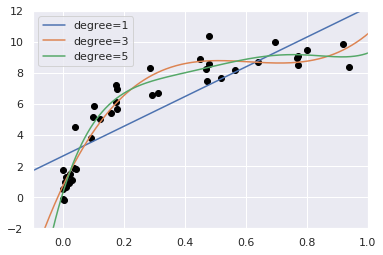

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # 用Seaborn可视化

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

> The knob controlling model complexity in this case is the degree of the polynomial, which can be any non-negative integer.
A useful question to answer is this: what degree of polynomial provides a suitable trade-off between bias (under-fitting) and variance (over-fitting)?

这个例子中控制模型复杂度的开关就是多项式的阶数，可以使任何非负的整数。这里有用的问题是：哪个阶的多项式在偏差（欠拟合）和方差（过拟合）之间合适的平衡？

> We can make progress in this by visualizing the validation curve for this particular data and model; this can be done straightforwardly using the ``validation_curve`` convenience routine provided by Scikit-Learn.
Given a model, data, parameter name, and a range to explore, this function will automatically compute both the training score and validation score across the range:

我们还可以进一步将这个特殊的数据和模型的验证曲线绘制出来；这可以直接通过Scikit-Learn提供的`validation_curve`工具完成。给定模型、数据、参数名称和一个范围，这个函数能够自动计算范围内所有的训练分数和验证分数：

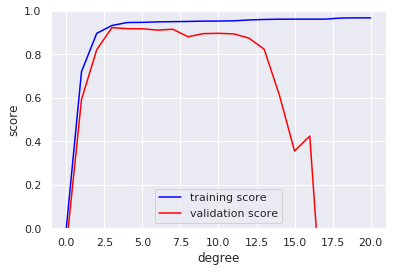

In [13]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

> This shows precisely the qualitative behavior we expect: the training score is everywhere higher than the validation score; the training score is monotonically improving with increased model complexity; and the validation score reaches a maximum before dropping off as the model becomes over-fit.

上图精确的展示了我们期望的定量行为：训练分数在任何地方都高于验证分数；训练分数是一个单调递增函数，随着模型复杂度增加而增加；然而验证分数在达到最大值后会因为过拟合而开始下降。

> From the validation curve, we can read-off that the optimal trade-off between bias and variance is found for a third-order polynomial; we can compute and display this fit over the original data as follows:

从验证曲线中，我们可以看到最优的偏差和方差平衡是在三阶的多项式出现；我们可以在原始数据上计算并展示这个模型：

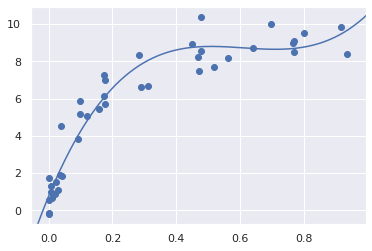

In [14]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

> Notice that finding this optimal model did not actually require us to compute the training score, but examining the relationship between the training score and validation score can give us useful insight into the performance of the model.

请注意寻找这个最优模型并不需要计算训练分数，但是检验训练分数和验证分数之间的关系能为我们提供模型性能的内在含义。

## Learning Curves

## 学习曲线

> One important aspect of model complexity is that the optimal model will generally depend on the size of your training data.
For example, let's generate a new dataset with a factor of five more points:

对于模型复杂度来说一个重要的相关性是它依赖于训练数据的规模。例如，我们创建一个数据集，具有5倍数量的样本：

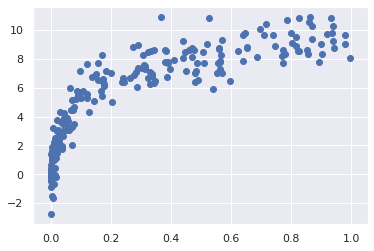

In [15]:
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

> We will duplicate the preceding code to plot the validation curve for this larger dataset; for reference let's over-plot the previous results as well:

我们重复前面的代码来绘制这个大的数据集的验证曲线；为了参考我们将前面的结果也画出来：

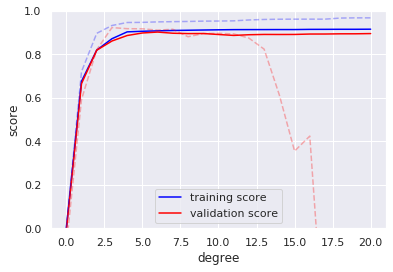

In [16]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                            'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

> The solid lines show the new results, while the fainter dashed lines show the results of the previous smaller dataset.
It is clear from the validation curve that the larger dataset can support a much more complicated model: the peak here is probably around a degree of 6, but even a degree-20 model is not seriously over-fitting the data—the validation and training scores remain very close.

实现展示新的结果，而虚线展示的是前面小数据集的结果。从验证曲线很明显看出大的数据集能够支持更复杂的模型：上图中的峰值大约出现在阶数6的位置上，但是甚至到了20阶的多项式模型中，也没有出现严重的过拟合，验证分数和训练分数依然很接近。

> Thus we see that the behavior of the validation curve has not one but two important inputs: the model complexity and the number of training points.
It is often useful to to explore the behavior of the model as a function of the number of training points, which we can do by using increasingly larger subsets of the data to fit our model.
A plot of the training/validation score with respect to the size of the training set is known as a *learning curve.*

因此我们看到了验证曲线不止有一个而是有两个重要的输入参数：模型复杂度和数据样本量。研究模型的性能与样本量之间的关系函数经常也很有帮助，我们可以通过不断增加数据中用来训练的子数据集规模来进行研究。绘制一幅训练/验证分数随着训练集规模变化的图像被成为*学习曲线*。

> The general behavior we would expect from a learning curve is this:

> - A model of a given complexity will *overfit* a small dataset: this means the training score will be relatively high, while the validation score will be relatively low.
- A model of a given complexity will *underfit* a large dataset: this means that the training score will decrease, but the validation score will increase.
- A model will never, except by chance, give a better score to the validation set than the training set: this means the curves should keep getting closer together but never cross.

从学习曲线中我们一般可以观察到下面的结论：

- 在小数据集的情况下，一个给定复杂度的模型很可能会*过拟合*：这意味着训练分数相对来说比较高而验证分数比较低。
- 在大数据集的情况下，一个给定复杂度的模型很可能会*欠拟合*：这意味着训练分数会下降而验证分数会上升。
- 一个模型应该永远（除非很偶然）在训练集给出比测试集更高的分值：这意味着两根曲线会一直接近但是不会相交。

> With these features in mind, we would expect a learning curve to look qualitatively like that shown in the following figure:

有了上述结论，我们预计的学习曲线如下图：

![](figures/05.03-learning-curve.png)
[附录中生成图像的代码](06.00-Figure-Code.ipynb#Learning-Curve)

> The notable feature of the learning curve is the convergence to a particular score as the number of training samples grows.
In particular, once you have enough points that a particular model has converged, *adding more training data will not help you!*
The only way to increase model performance in this case is to use another (often more complex) model.

学习曲线的一个著名特征就是当训练样本量增加时，两根曲线会收敛。这意味着，一旦你已经有了足够的样本量使得某种模型已经收敛的话，*增加更多的训练数据不会提供任何帮助*。在这种情况下提升模型性能的唯一方法就是使用另一个（通常更复杂）的模型。

### Learning curves in Scikit-Learn

### Scikit-Learn中的学习曲线

> Scikit-Learn offers a convenient utility for computing such learning curves from your models; here we will compute a learning curve for our original dataset with a second-order polynomial model and a ninth-order polynomial:

Scikit-Learn提供了一个方便的工具来计算模型的学习曲线；下面我们计算我们原始数据集在二阶多项式模型和九阶多项式模型上的学习曲线：

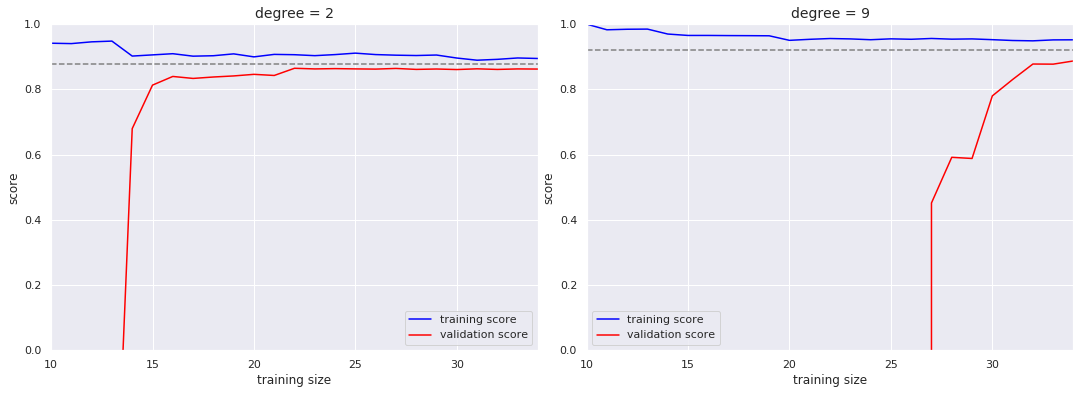

In [17]:
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv=7,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

> This is a valuable diagnostic, because it gives us a visual depiction of how our model responds to increasing training data.
In particular, when your learning curve has already converged (i.e., when the training and validation curves are already close to each other) *adding more training data will not significantly improve the fit!*
This situation is seen in the left panel, with the learning curve for the degree-2 model.

这是一项非常有价值的价差，因为它为我们提供了模型随着训练数据性能变化的可视化展示。而且当你的学习曲线已经收敛时（例如当训练和验证曲线已经非常接近的情况下）*增加更多的训练数据不会显著的提升拟合度*。这个结论很容易从左图二阶模型的学习曲线中获得。

> The only way to increase the converged score is to use a different (usually more complicated) model.
We see this in the right panel: by moving to a much more complicated model, we increase the score of convergence (indicated by the dashed line), but at the expense of higher model variance (indicated by the difference between the training and validation scores).
If we were to add even more data points, the learning curve for the more complicated model would eventually converge.

要提升已经收敛的学习曲线的性能唯一方法就是使用一个不同的（通常更复杂的）模型。我们可以从右图中看到：当使用了复杂的多的模型后，我们将收敛的分数值（使用虚线表示）提升了，付出的代价是更高的模型方差（图中训练曲线和验证曲线的间距）。如果我们继续增加更多的样本，更复杂模型的学习曲线最终也会收敛。

> Plotting a learning curve for your particular choice of model and dataset can help you to make this type of decision about how to move forward in improving your analysis.

绘制模型和数据集的学习曲线能帮助你作出进一步改善性能的决定。

## Validation in Practice: Grid Search

## 验证实践：网格搜索

> The preceding discussion is meant to give you some intuition into the trade-off between bias and variance, and its dependence on model complexity and training set size.
In practice, models generally have more than one knob to turn, and thus plots of validation and learning curves change from lines to multi-dimensional surfaces.
In these cases, such visualizations are difficult and we would rather simply find the particular model that maximizes the validation score.

前面的讨论意在为你提供直观的偏差和方差权衡的知识，它取决于模型复杂度和训练集规模。在实践中，模型通常有多于一个开关进行调节，因此前面关于验证曲线和学习曲线的二维线条就会变成多维平面。在这些情况下，要将它可视化出来是很困难的，并且我们更希望简单的找到特定模型能最大化验证分数。

> Scikit-Learn provides automated tools to do this in the grid search module.
Here is an example of using grid search to find the optimal polynomial model.
We will explore a three-dimensional grid of model features; namely the polynomial degree, the flag telling us whether to fit the intercept, and the flag telling us whether to normalize the problem.
This can be set up using Scikit-Learn's ``GridSearchCV`` meta-estimator:

Scikit-Learn提供了自动化的工具来完成这项任务，它们在网格搜索模块中。下面是一个使用网格搜索找到最优多项式模型的例子。我们会探索模型特征的一个三维网格；包括多项式阶数，一个是否你和截距的标志和一个是否归一化问题的标志。这可以通过Scikit-Learn的`GridSearchCV`元评估器来设置：

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

> Notice that like a normal estimator, this has not yet been applied to any data.
Calling the ``fit()`` method will fit the model at each grid point, keeping track of the scores along the way:

网格搜索模型和普通模型一样，实例化后还未应用到任何数据上。通过调用`fit()`方法会将模型的每个网格点拟合到数据上，同时过程中保存了验证的分数：

In [19]:
grid.fit(X, y);

/home/wangy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


> Now that this is fit, we can ask for the best parameters as follows:

拟合完后，我们可以使用下面代码来获得最佳参数：

In [20]:
grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

> Finally, if we wish, we can use the best model and show the fit to our data using code from before:

最终，如果我们希望，我们可以使用代码将最佳模型、数据及它们的拟合情况绘制出来：

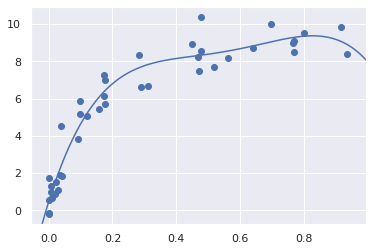

In [21]:
model = grid.best_estimator_

plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

> The grid search provides many more options, including the ability to specify a custom scoring function, to parallelize the computations, to do randomized searches, and more.
For information, see the examples in [In-Depth: Kernel Density Estimation](05.13-Kernel-Density-Estimation.ipynb) and [Feature Engineering: Working with Images](05.14-Image-Features.ipynb), or refer to Scikit-Learn's [grid search documentation](http://Scikit-Learn.org/stable/modules/grid_search.html).

网格搜索提供很多其他参数，包括指定自定义的评分函数，并行化计算和执行随机搜索等等。需要更多信息，参见[深入：核密度估计](05.13-Kernel-Density-Estimation.ipynb)和[特征工程](05.14-Image-Features.ipynb)，或者参考Scikit-Learn的[网格搜索在线文档](http://Scikit-Learn.org/stable/modules/grid_search.html)。

## Summary

## 总结

> In this section, we have begun to explore the concept of model validation and hyperparameter optimization, focusing on intuitive aspects of the bias–variance trade-off and how it comes into play when fitting models to data.
In particular, we found that the use of a validation set or cross-validation approach is *vital* when tuning parameters in order to avoid over-fitting for more complex/flexible models.

在本节中，我们开始探讨模型验证和超参数优化的概念，聚焦在偏差方差权衡的直观概念和它在模型拟合数据时扮演的角色。特别是，我们强调使用测试集验证和交叉验证方法的重要性，当在复杂/灵活模型中调节参数时要避免过拟合。

> In later sections, we will discuss the details of particularly useful models, and throughout will talk about what tuning is available for these models and how these free parameters affect model complexity.
Keep the lessons of this section in mind as you read on and learn about these machine learning approaches!

在后续章节中，我们会讨论每个有用模型的细节，并在过程中介绍这些模型可以调节哪些参数以及这些参数如果影响模型复杂度。请将本节的内容牢记，当你在后面继续学习机器学习方法的时候，本节内容会提供重要的帮助。